In [0]:
import tensorflow_datasets as tfds
from tensorflow_datasets import features

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import nltk
from nltk.stem.lancaster import LancasterStemmer
from nltk.corpus import stopwords

from string import punctuation 
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, GRU, LSTM
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
data = tfds.load('imdb_reviews')

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4FDPUR/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4FDPUR/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4FDPUR/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


## Preprocessing

In [3]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
stem = LancasterStemmer() # aggressive than Porter algoritm
stop = stopwords.words('english') # maybe stopwords not be useful
stop[:5]

['i', 'me', 'my', 'myself', 'we']

tensorflow dataset to array

In [0]:
X, Y = [], [] # original data
X_stop = [] # text without stopwords
X_stem = [] # steming text 
X_stop_stem = [] # steming and without stopwords

In [0]:
html_teg = re.compile(r'<.*?>')

In [7]:
%%time

for g in data['train']: 

    text = g['text'].numpy().decode() # rewiew film in byte string

    text = html_teg.sub('', text) # text have html

    X.append(text)

    text = ''.join(x for x in text if x not in punctuation) # clean text

    text_stop = ' '.join(word for word in text.lower().split() if
                         word not in stop)
    X_stop.append(text_stop)

    stem_text = ' '.join(stem.stem(word) for word in text.split())
    X_stem.append(stem_text)

    stem_stop_text = ' '.join(stem.stem(word) for word in text_stop.split())
    X_stop_stem.append(stem_stop_text)

    Y.append(g['label'].numpy())

CPU times: user 1min 56s, sys: 1.28 s, total: 1min 57s
Wall time: 1min 54s


same for test data

In [0]:
X_test, Y_test = [], []
X_stop_test = [] 
X_stop_stem_test = []

In [9]:
%%time

for g in data['test']: 

    text = g['text'].numpy().decode() # rewiew film in byte string

    text = html_teg.sub('', text) # text have html

    X_test.append(text)

    text = ''.join(x for x in text if x not in punctuation) # clean text

    text_stop = ' '.join(word for word in text.lower().split() if
                         word not in stop)
    X_stop_test.append(text_stop)

    stem_stop_text = ' '.join(stem.stem(word) for word in text_stop.split())
    X_stop_stem_test.append(stem_stop_text)

    Y_test.append(g['label'].numpy())

CPU times: user 56.9 s, sys: 1.42 s, total: 58.4 s
Wall time: 54.8 s


## Data Analysis

more comfortably

In [0]:
X = np.array(X)
X_stop = np.array(X_stop)
X_stem = np.array(X_stem)
X_stop_stem = np.array(X_stop_stem)
Y = np.array(Y)

X_test = np.array(X_test)
X_stop_test = np.array(X_stop_test)
X_stop_stem_test = np.array(X_stop_stem_test)
Y_test = np.array(Y_test)

### See on data

Negative

In [11]:
X[Y == 0][0] # i don't watch McBain

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

In [12]:
X_stem[Y == 0][0]

'thi was an absolv terr movy dont be lur in by christopher walk or michael ironsid both ar gre act but thi must simply be their worst rol in hist ev their gre act could not redeem thi movy ridic storylin thi movy is an ear nin us propagand piec the most pathet scen wer thos when the columb rebel wer mak their cas for revolv mar conchit alonso appear phony and her pseudolov affair with walk was noth but a pathet emot plug in a movy that was devoid of any real mean i am disappoint that ther ar movy lik thi ruin act lik christopher walk good nam i could bar sit through it'

Positive

In [13]:
X[Y == 1][0] # maybe Moonstruck is well

'This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.'

In [14]:
X_stem[Y == 1][0]

'thi is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with it own busy as you descend into a big armchair and mellow for a coupl of hour wond perform from cher and nicola cag as alway gent row the plot along ther ar no rapid to cross no dang wat just a warm and witty paddl through new york lif at it best a famy film in every sens and on that deserv the pra it receiv'

### Visualization

propotion with pie

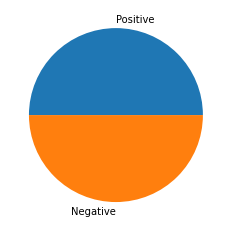

In [15]:
_, ax = plt.subplots()

ax.pie(
    (len(Y[Y==1]), len(Y[Y==0])),
    labels = ('Positive', 'Negative')
)
plt.show()

In [16]:
len(Y[Y==1]) == len(Y[Y==0]) # equal

True

In [17]:
len(Y[Y == 1])

12500

## TfidfVectorizer

### Original data

In [0]:
tfidf = TfidfVectorizer()

In [19]:
%%time
out = tfidf.fit_transform(X)
print(out.shape) # all string on all world

(25000, 75907)
CPU times: user 4.41 s, sys: 10.6 ms, total: 4.42 s
Wall time: 4.44 s


top 5 words in "dirty data"

In [0]:
sort_idx = np.ravel(out.sum(axis=0).argsort(axis=1))[::-1]

In [21]:
np.array(tfidf.get_feature_names())[sort_idx][:5]

array(['the', 'and', 'of', 'to', 'is'], dtype='<U74')

for logreg

In [0]:
x_train = tfidf.transform(X)
x_test = tfidf.transform(X_test)

### Data without stop words

In [23]:
%%time
tfidf2 = TfidfVectorizer()
out2 = tfidf2.fit_transform(X_stop)
print(out2.shape) 

(25000, 141849)
CPU times: user 3.08 s, sys: 9.84 ms, total: 3.09 s
Wall time: 3.09 s


In [0]:
sort_idx2 = np.ravel(out2.sum(axis=0).argsort(axis=1))[::-1]

top 5 words

In [25]:
np.array(tfidf2.get_feature_names())[sort_idx2][:5]

array(['movie', 'film', 'one', 'like', 'good'], dtype='<U66')

for logreg

In [0]:
x2_train = tfidf2.transform(X_stop)
x2_test = tfidf2.transform(X_stop_test)

### Data without stop words, with steming

In [27]:
%%time
tfidf3 = TfidfVectorizer()
out3 = tfidf3.fit_transform(X_stop_stem)
print(out3.shape) 

(25000, 100204)
CPU times: user 2.71 s, sys: 8.77 ms, total: 2.72 s
Wall time: 2.72 s


In [0]:
sort_idx3 = np.ravel(out3.sum(axis=0).argsort(axis=1))[::-1]

top 5 words in data without stop words, with steming

In [29]:
np.array(tfidf3.get_feature_names())[sort_idx3][:5]

array(['movy', 'film', 'on', 'act', 'lik'], dtype='<U64')

for logreg

In [0]:
x3_train = tfidf3.transform(X_stop_stem)
x3_test = tfidf3.transform(X_stop_stem_test)

## Logistic Regression

In [0]:
precision_pos, recall_pos = {}, {} # Positive precision and reccall
precision_neg, recall_neg = {}, {} # Negative precision and reccall
accuracy = {} # i like accuracy

In [0]:
def add_stat(model_name: str, pred):
    
    prec_pos = precision_score(Y_test, pred, average='binary', pos_label=1)
    rec_pos = recall_score(Y_test, pred, average='binary', pos_label=1)

    print(f'Precison for positive is {prec_pos}\nRecall for positive is {rec_pos}')

    precision_pos[model_name] = prec_pos
    recall_pos[model_name] = rec_pos

    prec_neg = precision_score(Y_test, pred, average='binary', pos_label=0)
    rec_neg = recall_score(Y_test, pred, average='binary', pos_label=0)

    print(f'Precison for negative is {prec_neg}\nRecall for negative is {rec_neg}')
        
    precision_neg[model_name] = prec_neg
    recall_neg[model_name] = rec_neg

    print(f'Accuracy is {accuracy_score(pred, Y_test)}')
    accuracy[model_name] = accuracy_score(pred, Y_test)

### Original data

In [0]:
# %%time
# model1 = LogisticRegression(random_state=42, n_jobs=-1)

# params = {
#     'C': np.linspace(6, 9, 5)
# }

# grid_search = GridSearchCV(model1, params, 
#                            n_jobs=-1, cv=3,
#                            return_train_score=True)

# grid_search.fit(x_train, Y)

In [0]:
# grid_search.best_params_, grid_search.best_score_

In [35]:
%%time
model1 = LogisticRegression(random_state=42,
                           n_jobs=-1,
                           C=8.25).fit(x_train, Y)

CPU times: user 34.9 ms, sys: 252 ms, total: 287 ms
Wall time: 3.81 s


In [36]:
add_stat('Logreg orig', model1.predict(x_test))

Precison for positive is 0.8887081028311097
Recall for positive is 0.87392
Precison for negative is 0.87598363235757
Recall for negative is 0.89056
Accuracy is 0.88224


### Data without stop words

In [0]:
# %%time
# model2 = LogisticRegression(random_state=42, n_jobs=-1)

# params2 = {
#     'C': np.linspace(4, 6, 10)
# }

# grid_search2 = GridSearchCV(model2, params2, 
#                            n_jobs=-1, cv=3,
#                            return_train_score=True)

# grid_search2.fit(x2_train, Y)

In [0]:
# grid_search2.best_params_, grid_search2.best_score_ 

In [39]:
%%time
model2 = LogisticRegression(random_state=42,
                           n_jobs=-1,
                           C=4.5).fit(x2_train, Y)

CPU times: user 17.4 ms, sys: 17.9 ms, total: 35.3 ms
Wall time: 3.59 s


In [40]:
add_stat('Logreg stop words', model2.predict(x2_test))

Precison for positive is 0.8866279069767442
Recall for positive is 0.8784
Precison for negative is 0.8795180722891566
Recall for negative is 0.88768
Accuracy is 0.88304


### Data without stop words and steming 

In [0]:
# %%time
# model3 = LogisticRegression(random_state=42, n_jobs=-1)

# params3 = {
#     'C': np.linspace(2, 4, 10)
# }

# grid_search3 = GridSearchCV(model3, params3, 
#                            n_jobs=-1, cv=3,
#                            return_train_score=True)

# grid_search3.fit(x3_train, Y)

In [0]:
# grid_search3.best_params_, grid_search3.best_score_ 

In [43]:
%%time
model3 = LogisticRegression(random_state=42,
                           n_jobs=-1,
                           C=3.5).fit(x3_train, Y)

CPU times: user 17.6 ms, sys: 13 ms, total: 30.6 ms
Wall time: 2.49 s


In [44]:
add_stat('Logreg stop words and steming', model3.predict(x3_test))

Precison for positive is 0.8737206865984366
Recall for positive is 0.86736
Precison for negative is 0.868318640298626
Recall for negative is 0.87464
Accuracy is 0.871


## Tokenizer + Dense

In [0]:
tokenizer = Tokenizer(num_words=2**13)

In [46]:
%%time
tokenizer.fit_on_texts(X_stop_stem)

CPU times: user 2.82 s, sys: 22.7 ms, total: 2.84 s
Wall time: 2.85 s


In [0]:
x_train = tokenizer.texts_to_matrix(X_stop_stem, mode='binary')

In [48]:
x_train.shape

(25000, 8192)

In [49]:
X_test = tokenizer.texts_to_matrix(X_stop_stem_test, mode='binary')
X_test.shape

(25000, 8192)

### Keras Dense Model

In [0]:
model = Sequential([
    Dense(2048, input_shape=(2**13,), activation='relu'), # 2**13 is tokenizer num words 
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='sigmoid')
])

In [51]:
model.compile(loss=BinaryCrossentropy(),
             optimizer=Adam(1e-3),
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              16779264  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 17,041,794
Trainable params: 17,041,794
Non-trainable params: 0
_________________________________________________________________


### train model

In [0]:
y_train = to_categorical(Y)
y_test = to_categorical(Y_test)

In [53]:
%%time
history = model.fit(x_train, y_train, epochs=4, batch_size=1000)

Epoch 1/4
25/25 [==============================] - 1s 25ms/step - loss: 0.4294 - accuracy: 0.8105
Epoch 2/4
25/25 [==============================] - 1s 24ms/step - loss: 0.2169 - accuracy: 0.9191
Epoch 3/4
25/25 [==============================] - 1s 24ms/step - loss: 0.1271 - accuracy: 0.9571
Epoch 4/4
25/25 [==============================] - 1s 22ms/step - loss: 0.0575 - accuracy: 0.9843
CPU times: user 3.92 s, sys: 640 ms, total: 4.56 s
Wall time: 5.09 s


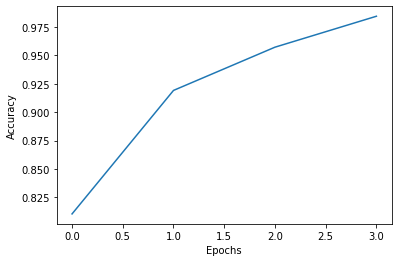

In [54]:
plt.plot(history.history['accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

### score

In [55]:
pred = model.predict_classes(X_test)
add_stat('Dense', pred)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Precison for positive is 0.8507404822827014
Recall for positive is 0.87776
Precison for negative is 0.8737503098405354
Recall for negative is 0.846
Accuracy is 0.86188


## Recurrent Neural Networks

In [0]:
x_train = pad_sequences(tokenizer.texts_to_sequences(X_stop_stem))
x_test =  pad_sequences(tokenizer.texts_to_sequences(X_stop_stem_test))

### GRU

In [0]:
gru = Sequential([
    Embedding(2**13, 3), # 2**13 is tokenizer num words 
    GRU(3),
    Dense(2, activation='sigmoid')
])

In [90]:
gru.compile(loss=BinaryCrossentropy(),
             optimizer=Adam(1e-3),
             metrics=['accuracy'])
gru.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 3)           24576     
_________________________________________________________________
gru_7 (GRU)                  (None, 3)                 72        
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 8         
Total params: 24,656
Trainable params: 24,656
Non-trainable params: 0
_________________________________________________________________


train

In [91]:
%%time
history = gru.fit(x_train, y_train, epochs=12, 
                  batch_size=100, validation_data=(x_test, y_test)) 
# batch size 10 because embedding very big

Epoch 1/12
250/250 [==============================] - 20s 82ms/step - loss: 0.6813 - accuracy: 0.6147 - val_loss: 0.6182 - val_accuracy: 0.6862
Epoch 2/12
250/250 [==============================] - 20s 82ms/step - loss: 0.4539 - accuracy: 0.8174 - val_loss: 0.4383 - val_accuracy: 0.8090
Epoch 3/12
250/250 [==============================] - 21s 82ms/step - loss: 0.3665 - accuracy: 0.8556 - val_loss: 0.3976 - val_accuracy: 0.8316
Epoch 4/12
250/250 [==============================] - 20s 82ms/step - loss: 0.3193 - accuracy: 0.8796 - val_loss: 0.3888 - val_accuracy: 0.8359
Epoch 5/12
250/250 [==============================] - 20s 82ms/step - loss: 0.2946 - accuracy: 0.8917 - val_loss: 0.3959 - val_accuracy: 0.8335
Epoch 6/12
250/250 [==============================] - 20s 81ms/step - loss: 0.2755 - accuracy: 0.8990 - val_loss: 0.3923 - val_accuracy: 0.8360
Epoch 7/12
250/250 [==============================] - 20s 81ms/step - loss: 0.2596 - accuracy: 0.9061 - val_loss: 0.4170 - val_accuracy:

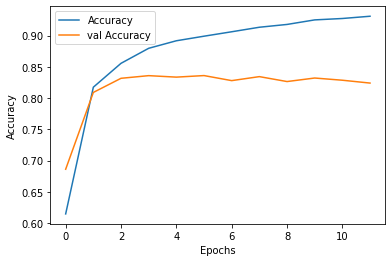

In [92]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Accuracy','val Accuracy'])
plt.show()

score

In [93]:
pred = gru.predict_classes(x_test)
add_stat('GRU', pred)

Precison for positive is 0.8398221178050008
Recall for positive is 0.80072
Precison for negative is 0.8095856902614279
Recall for negative is 0.84728
Accuracy is 0.824


### LSTM

In [0]:
lstm = Sequential([
     Embedding(2**13, 3), # 2**13 is tokenizer num words 
     LSTM(3),
     Dense(2, activation='sigmoid')
])

In [95]:
lstm.compile(loss=BinaryCrossentropy(),
             optimizer=Adam(1e-3),
             metrics=['accuracy'])
lstm.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 3)           24576     
_________________________________________________________________
lstm (LSTM)                  (None, 3)                 84        
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 8         
Total params: 24,668
Trainable params: 24,668
Non-trainable params: 0
_________________________________________________________________


In [97]:
%%time
history = lstm.fit(x_train, y_train, epochs=10, 
                  batch_size=100, validation_data=(x_test, y_test)) 
# batch size 100 because embedding very big

Epoch 1/10
250/250 [==============================] - 15s 60ms/step - loss: 0.6489 - accuracy: 0.7098 - val_loss: 0.5435 - val_accuracy: 0.8455
Epoch 2/10
250/250 [==============================] - 15s 60ms/step - loss: 0.4670 - accuracy: 0.8751 - val_loss: 0.4360 - val_accuracy: 0.8628
Epoch 3/10
250/250 [==============================] - 15s 59ms/step - loss: 0.3615 - accuracy: 0.9050 - val_loss: 0.3859 - val_accuracy: 0.8639
Epoch 4/10
250/250 [==============================] - 15s 59ms/step - loss: 0.2944 - accuracy: 0.9211 - val_loss: 0.3702 - val_accuracy: 0.8624
Epoch 5/10
250/250 [==============================] - 15s 60ms/step - loss: 0.2498 - accuracy: 0.9312 - val_loss: 0.3761 - val_accuracy: 0.8570
Epoch 6/10
250/250 [==============================] - 15s 59ms/step - loss: 0.2190 - accuracy: 0.9409 - val_loss: 0.3665 - val_accuracy: 0.8573
Epoch 7/10
250/250 [==============================] - 15s 58ms/step - loss: 0.2147 - accuracy: 0.9360 - val_loss: 0.3698 - val_accuracy:

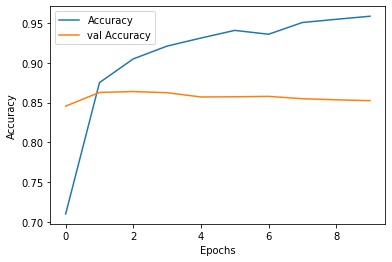

In [98]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Accuracy','val Accuracy'])
plt.show()

In [99]:
pred = lstm.predict_classes(x_test)
add_stat('LSTM', pred)

Precison for positive is 0.8642301967917976
Recall for positive is 0.83616
Precison for negative is 0.841314117464745
Recall for negative is 0.86864
Accuracy is 0.8524


## Summary

result to pandas 

In [100]:
precision_pos = pd.Series(precision_pos)
precision_neg = pd.Series(precision_neg)
recall_pos = pd.Series(recall_pos)
recall_neg = pd.Series(recall_neg)
accuracy = pd.Series(accuracy)
result = pd.DataFrame({'accuracy': accuracy, 
                     'precision positive': precision_pos,
                     'precision negative': precision_neg,
                     'recall positive': recall_pos,
                     'recall negative': recall_neg})
result

,accuracy,precision positive,precision negative,recall positive,recall negative
Logreg orig,0.88224,0.888708,0.875984,0.87392,0.89056
Logreg stop words,0.88304,0.886628,0.879518,0.87840,0.88768
Logreg stop words and steming,0.87100,0.873721,0.868319,0.86736,0.87464
Dense,0.86188,0.850740,0.873750,0.87776,0.84600
GRU,0.82400,0.839822,0.809586,0.80072,0.84728
LSTM,0.85240,0.864230,0.841314,0.83616,0.86864


In [101]:
result.sort_values(by=['precision positive'], ascending=False)

,accuracy,precision positive,precision negative,recall positive,recall negative
Logreg orig,0.88224,0.888708,0.875984,0.87392,0.89056
Logreg stop words,0.88304,0.886628,0.879518,0.87840,0.88768
Logreg stop words and steming,0.87100,0.873721,0.868319,0.86736,0.87464
LSTM,0.85240,0.864230,0.841314,0.83616,0.86864
Dense,0.86188,0.850740,0.873750,0.87776,0.84600
GRU,0.82400,0.839822,0.809586,0.80072,0.84728


In [102]:
result.sort_values(by=['recall positive'], ascending=False)

,accuracy,precision positive,precision negative,recall positive,recall negative
Logreg stop words,0.88304,0.886628,0.879518,0.87840,0.88768
Dense,0.86188,0.850740,0.873750,0.87776,0.84600
Logreg orig,0.88224,0.888708,0.875984,0.87392,0.89056
Logreg stop words and steming,0.87100,0.873721,0.868319,0.86736,0.87464
LSTM,0.85240,0.864230,0.841314,0.83616,0.86864
GRU,0.82400,0.839822,0.809586,0.80072,0.84728


Summary:  
**Logistic Regression** is a enough for imdb reviews.

> + very easy training   
> + work with "dirty" data

**Dense NN** slightly worse than LogReg.  

> + training faster then Embedding 
> - requires more resources than LogReg

**LSTM and GRU** it's very hard model for imdb reviews.

> - long training
> - requires very much resources

In this data stemming + remove stop words helped NN, but LogReg does not require it all